In [2]:
import os
import pandas as pd
import numpy as np
import pickle

from keras.models import Sequential
from keras.layers import *

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


In [3]:
global_params = pickle.load(open("global_params.p", "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [4]:
X_train = np.load(os.path.join("data", "Kdata", "X_train.npy"))
y_train = np.load(os.path.join("data", "Kdata", "y_train.npy"))
X_val = np.load(os.path.join("data", "Kdata", "X_val.npy"))
y_val = np.load(os.path.join("data", "Kdata", "y_val.npy"))

In [5]:
from keras import backend as K

def macroPrec(y_true, y_pred):
    # a custom metric
    # note that any metric is computed per batch during training
    # (hence one needs large batches for it to make sense)
    # also, there is the implicit 0.5 treshold due to the round function
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec

def macroRecall(y_true, y_pred):
    # a custom metric
    # note that any metric is computed per batch during training
    # (hence one needs large batches for it to make sense)
    # also, there is the implicit 0.5 treshold due to the round function
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):
    # a custom metric
    # note that any metric is computed per batch during training
    # (hence one needs large batches for it to make sense)
    # also, there is the implicit 0.5 treshold due to the round function
    
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) )
    
    return macroF1


def fuzzy_macroF1_flip(y_true, y_pred):
    # a custom loss function
    # no clippping or rounding as those are not differentiable
    
    def recall(y_true, y_pred):

        true_positives = K.sum(y_true * y_pred, axis=0)
        actual_ones = K.sum(y_true, axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(y_true * y_pred, axis=0)
        positives = K.sum(y_pred, axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) ) 
    
    return 1-macroF1

In [16]:
# some other global learning settings

batch_size = 3000
patience = 4
optimizer = 'adam' # 'rmsprop'
my_loss = fuzzy_macroF1_flip
my_metrics = [macroPrec, macroF1, macroRecall]

In [6]:
# auxiliary functions

# choose callback functions to be given in model.fit(...)
def callbacks(LRfactor=0.8):
    return [ReduceLROnPlateau(factor=LRfactor, patience = patience//2),
            EarlyStopping(monitor='val_macroF1', mode='max', patience=patience)
           ]

    
# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history):
    
    plt.figure(figsize=(18, 5))
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, 3, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, 3, 2)
    markers = ['b', 'r',  'g', 'y']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history.history[metric]
        val_results = history.history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    lr = history.history['lr'] # learning rate
    plt.plot(x, lr, 'k', label='Learning rate')
    plt.title('Learning rate')  
    plt.legend()

In [10]:
# the workhorse

class BlackBox():
    
    def __init__(self, layers, loss, metrics, callbacks=callbacks(), embedd = None, embedd_dims=[None]*3):
        
        self.layers = layers
        self.loss = loss
        self.metrics = metrics
        self.callbacks = callbacks
        self.history = None
        self.results = None
        
        self.model = Sequential()
        if embedd:
            self.input_dim = embedd_dims[0] # num_words
            self.output_dim = embedd_dims[1] # dimension of the embedding space
            self.input_length = embedd_dims[2] # padded_length
            self.embedd_weights = pickle.load(open(embedd, "rb"))
            
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=False))
            self.model.layers[0].trainable = False  # szczeżonego panbug szczeże
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
    
    def summary(self):
        return self.model.summary()
    
    def fit(self, epochs=200):
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=class_weights,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=self.callbacks,
            verbose = 1        
            )
        
    def reset(self):
        
        self.history = None
        self.results = None
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        
    def evaluate(self):
        print(f'Loss function: {self.loss.__name__ if callable(self.loss) else self.loss}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        return self.results
    
    def plot(self):
        plot_history(self.history)
        
    def save(self, file):
        self.model.save(file)
        
    def save_embedd(self, name):
        pickle.dump(self.model.layers[0].get_weights(), open(f"my_embedd_weights_{name}.p", "wb")) 
 


---

In [44]:
layers0 = [SimpleRNN(10, dropout=0.0, recurrent_dropout=0.0)
          ]

model0 = BlackBox(layers=layers0, loss=my_loss, metrics=my_metrics,\
                  embedd="my_embedd_weights_50dim_GlblAvg.p",\
                  embedd_dims=[num_words, 50, padded_length])
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 679, 50)           13865200  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10)                610       
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 66        
Total params: 13,865,876
Trainable params: 676
Non-trainable params: 13,865,200
_________________________________________________________________


In [46]:
model0.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/200
246000/500000 [=============>................] - ETA: 3:12 - loss: 0.8528 - macroPrec: 0.0258 - macroF1: 0.0322 - macroRecall: 0.0427

KeyboardInterrupt: 

---

In [ ]:
Bidirectional(LSTM(64))

In [ ]:
... = [Conv1D(96, 2),
           MaxPooling1D(4, 2),
           Dropout(rate=0.3),
           Conv1D(48, 3),
           MaxPooling1D(8, 4),
           Dropout(rate=0.15),
           Conv1D(12, 4),
           GlobalMaxPooling1D()
          ]

In [ ]:
... = [Conv1D(96, 2),
           MaxPooling1D(4, 2),
           Dropout(rate=0.3),
           Conv1D(48, 3),
           MaxPooling1D(8, 4),
           Dropout(rate=0.15),
           Conv1D(12, 4),
           GlobalMaxPooling1D()
          ]

In [49]:
layers1 = [Conv1D(50, 4),
           Flatten()
          ]

model1 = BlackBox(layers=layers1, loss=my_loss, metrics=my_metrics,\
                  embedd="my_embedd_weights_50dim_GlblAvg.p",\
                  embedd_dims=[num_words, 50, padded_length])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 679, 50)           13865200  
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 676, 50)           10050     
_________________________________________________________________
flatten_9 (Flatten)          (None, 33800)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 202806    
Total params: 14,078,056
Trainable params: 212,856
Non-trainable params: 13,865,200
_________________________________________________________________


In [50]:
model1.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/200
500000/500000 [==============================] - 577s 1ms/step - loss: 0.1354 - macroPrec: 0.8879 - macroF1: 0.8723 - macroRecall: 0.8648 - val_loss: 0.2009 - val_macroPrec: 0.8161 - val_macroF1: 0.8022 - val_macroRecall: 0.7935
Epoch 2/200
500000/500000 [==============================] - 579s 1ms/step - loss: 0.1008 - macroPrec: 0.9083 - macroF1: 0.9012 - macroRecall: 0.8964 - val_loss: 0.2052 - val_macroPrec: 0.8187 - val_macroF1: 0.7963 - val_macroRecall: 0.7815
Epoch 3/200
500000/500000 [==============================] - 589s 1ms/step - loss: 0.0977 - macroPrec: 0.9117 - macroF1: 0.9036 - macroRecall: 0.8980 - val_loss: 0.2008 - val_macroPrec: 0.8125 - val_macroF1: 0.8001 - val_macroRecall: 0.7922
Epoch 4/200
500000/500000 [==============================] - 589s 1ms/step - loss: 0.0961 - macroPrec: 0.9123 - macroF1: 0.9050 - macroRecall: 0.9001 - val_loss: 0.2019 - val_macroPrec: 0.8152 - val_macroF1: 0.7996 - val_macr

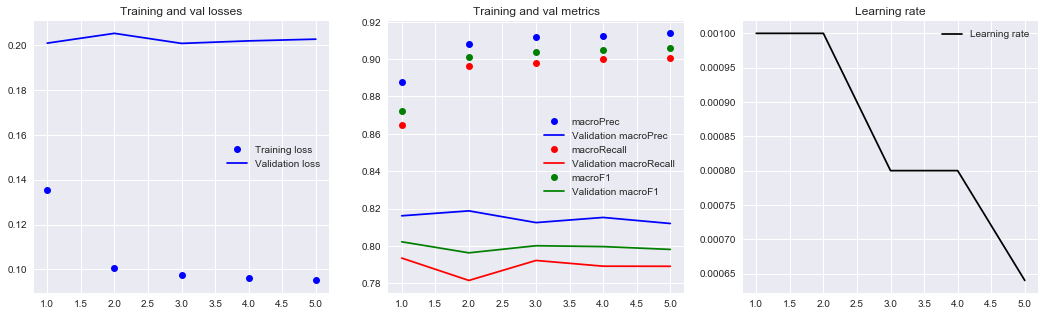

In [51]:
model1.plot()

In [28]:
layers1 = [Conv1D(40, 2),
           MaxPooling1D(2),
           Dropout(rate=0.3),
           Conv1D(30, 4),
           MaxPooling1D(4),
           Dropout(rate=0.1),
           Conv1D(20, 6),
           GlobalMaxPooling1D()
          ]

model1 = BlackBox(layers=layers1, loss=my_loss, metrics=my_metrics,\
                  embedd="my_embedd_weights_50dim_GlblAvg.p",\
                  embedd_dims=[num_words, 50, padded_length])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 678, 40)           4040      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 339, 40)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 339, 40)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 336, 30)           4830      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 84, 30)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 84, 30)            0         
__________

In [29]:
model1.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/200
500000/500000 [==============================] - 854s 2ms/step - loss: 0.3450 - macroPrec: 0.6867 - macroF1: 0.6683 - macroRecall: 0.6682 - val_loss: 0.2195 - val_macroPrec: 0.8016 - val_macroF1: 0.7864 - val_macroRecall: 0.7774
Epoch 2/200
500000/500000 [==============================] - 850s 2ms/step - loss: 0.1348 - macroPrec: 0.8745 - macroF1: 0.8702 - macroRecall: 0.8691 - val_loss: 0.2098 - val_macroPrec: 0.8036 - val_macroF1: 0.7931 - val_macroRecall: 0.7875
Epoch 3/200
500000/500000 [==============================] - 802s 2ms/step - loss: 0.1229 - macroPrec: 0.8858 - macroF1: 0.8802 - macroRecall: 0.8774 - val_loss: 0.2080 - val_macroPrec: 0.8070 - val_macroF1: 0.7939 - val_macroRecall: 0.7857
Epoch 4/200
500000/500000 [==============================] - 808s 2ms/step - loss: 0.1193 - macroPrec: 0.8892 - macroF1: 0.8830 - macroRecall: 0.8802 - val_loss: 0.2062 - val_macroPrec: 0.8026 - val_macroF1: 0.7954 - val_macr

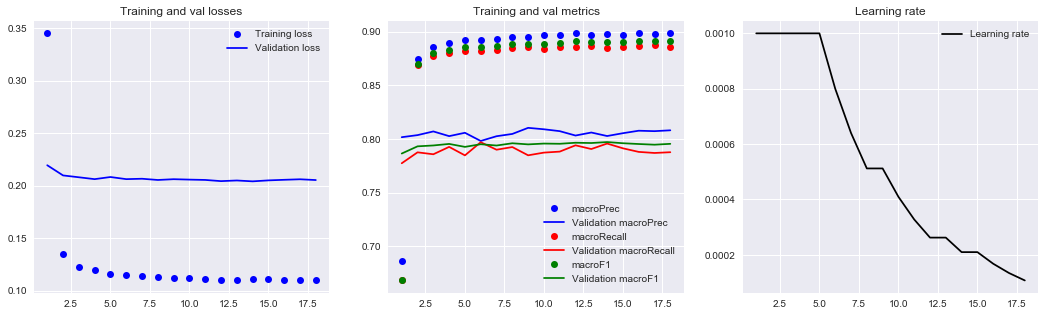

In [30]:
model1.plot()

In [22]:
model1.model.layers[0].get_config()['trainable']

False